In [19]:
import os, json, pickle, inspect
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler
from sklearn.model_selection import train_test_split

import utils
import commons
import models
from cough_datasets import CoughDatasets, CoughDatasetsCollate

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, f1_score

from tensorboard.backend.event_processing import event_accumulator

import warnings
warnings.simplefilter("ignore", UserWarning)

# =============================================================
# SECTION: Intialize Data
# =============================================================
INIT = False
MODEL_NAME = "try_resnet101_cam"
CONFIG_PATH = "configs/lstm_cnn.json"

model_dir = os.path.join("./logs", MODEL_NAME)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

config_save_path = os.path.join(model_dir, "config.json")
if INIT:
    with open(CONFIG_PATH, "r") as f:
      data = f.read()
    with open(config_save_path, "w") as f:
      f.write(data)
else:
    with open(config_save_path, "r") as f:
      data = f.read()

config = json.loads(data)
  
hps = utils.HParams(**config)
hps.model_dir = model_dir

BATCH_SIZE = hps.train.batch_size
ACCUMULATION_STEP = hps.train.accumulation_steps
assert (ACCUMULATION_STEP > 0) and (BATCH_SIZE % ACCUMULATION_STEP == 0)
cur_bs = BATCH_SIZE // ACCUMULATION_STEP

# =============================================================
# SECTION: Loading Data
# =============================================================

##### Label Umum Semua
Diseases_codes = [0, 1]
CLASS_NAMES = ["Negative TB", "Positive TB"]

df = pd.read_csv(f'{hps.data.db_path}/{hps.data.metadata_csv}')
df = df[df['cough_score'] >= 0.90].sample(frac=1, random_state=40)

df_solic = df[df['type_cough'] == 0].sample(frac=1, random_state=41)
df_long = df[df['type_cough'] == 1].sample(frac=1, random_state=42) # 0 Solic, 1 Longi
df_long_array = []
for i_rand in range(5):
    df_0 = df_long[df_long['disease_label'] == 0].sample(n=df_solic['disease_label'].value_counts()[0], random_state=i_rand * 4)
    df_1 = df_long[df_long['disease_label'] == 1].sample(n=df_solic['disease_label'].value_counts()[1], random_state=i_rand * 4)
    df_long_array.append(pd.concat([df_0, df_1], ignore_index=True, sort=False))

df = df_long
print(df.shape)

df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
df_issue = pd.read_csv("df_issue.csv")
df_train = df_train[~df_train['path_file'].isin(df_issue['wavname'])]
df_test = df_test[~df_test['path_file'].isin(df_issue['wavname'])]

class_frequencies = df_train['disease_label'].value_counts().to_dict()
total_samples = len(df_train)
class_weights = {cls: total_samples / (len(Diseases_codes) * freq) if freq != 0 else 0 for cls, freq in class_frequencies.items()}
weights_list = [class_weights[cls] for cls in Diseases_codes]
class_weights_tensor = torch.tensor(weights_list, device='cuda', dtype=torch.float)
print(class_weights_tensor)

# =============================================================
# SECTION: Setup Logger, Dataloader
# =============================================================
writer = SummaryWriter(log_dir=hps.model_dir)
writer_eval = SummaryWriter(log_dir=os.path.join(hps.model_dir, "eval"))

collate_fn = CoughDatasetsCollate(hps.data.many_class)
train_dataset = CoughDatasets(df_train.values, hps.data, train=True)
val_dataset = CoughDatasets(df_test.values, hps.data, train=False)

#train_sampler = DistributedBucketSampler(train_dataset, cur_bs, [32,300,400,500,600,700,800,900,1000], num_replicas=1, rank=0, shuffle=True)
#train_loader = DataLoader(train_dataset, num_workers=28, shuffle=False, pin_memory=True, collate_fn=collate_fn, batch_sampler=train_sampler)
train_loader = DataLoader(train_dataset, num_workers=28, shuffle=True, batch_size=cur_bs, pin_memory=True, drop_last=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, num_workers=28, shuffle=False, batch_size=hps.train.batch_size, pin_memory=True, drop_last=True, collate_fn=collate_fn)

print(next(iter(train_loader))[1][0].numpy().shape)

# =============================================================
# SECTION: Setup Logger, Dataloader
# =============================================================
epoch_str = 1
global_step = 0

pool_net = getattr(models, hps.model.pooling_model)
pool_model = pool_net(hps.model.feature_dim, **hps.model).cuda()

optimizer_p = torch.optim.AdamW(pool_model.parameters(), hps.train.learning_rate, betas=hps.train.betas, eps=hps.train.eps)
scheduler_p = torch.optim.lr_scheduler.ExponentialLR(optimizer_p, gamma=hps.train.lr_decay, last_epoch=epoch_str - 2)

_, _, _, _, epoch_str = utils.load_checkpoint(
    os.path.join(hps.model_dir, "best_pool.pth"),
    pool_model,
    optimizer_p,
    scheduler_p,
)


(647060, 5)
tensor([1.2897, 0.8166], device='cuda:0')
True
False
(80, 76)


In [20]:
pool_model.eval() 
all_preds, all_labels, all_wavnames, all_embeddings  = [], [], [], []
with torch.no_grad():
    for batch_idx, (wav_names, audio, attention_masks, dse_ids, spk_ids) in enumerate(tqdm(train_loader)):
        audio = audio.cuda(non_blocking=True).float().squeeze(1)
        attention_masks = attention_masks.cuda(non_blocking=True).float()
        dse_ids = dse_ids.cuda(non_blocking=True).float()
        spk_ids = spk_ids.cuda(non_blocking=True).long()

        x_lengths = torch.tensor(commons.compute_length_from_mask(attention_masks)).cuda(non_blocking=True).long()
        out_model = pool_model(audio)
        outputs = out_model[0]
        
        preds = torch.argmax(outputs, dim=1)
        dse_ids = np.argmax(dse_ids.cpu().detach().numpy(), axis=-1)

        all_wavnames.extend(wav_names)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(dse_ids)

    for batch_idx, (wav_names, audio, attention_masks, dse_ids, spk_ids) in enumerate(tqdm(val_loader)):
        audio = audio.cuda(non_blocking=True).float().squeeze(1)
        attention_masks = attention_masks.cuda(non_blocking=True).float()
        dse_ids = dse_ids.cuda(non_blocking=True).float()
        spk_ids = spk_ids.cuda(non_blocking=True).long()

        x_lengths = torch.tensor(commons.compute_length_from_mask(attention_masks)).cuda(non_blocking=True).long()
        out_model = pool_model(audio)
        outputs = out_model[0]
        
        preds = torch.argmax(outputs, dim=1)
        dse_ids = np.argmax(dse_ids.cpu().detach().numpy(), axis=-1)

        all_wavnames.extend(wav_names)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(dse_ids)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_wavnames = np.array(all_wavnames)

df_result = pd.DataFrame({
    'wavname': all_wavnames,
    'label': all_labels,
    'pred': all_preds
})

accuracy_score(all_labels, all_preds)

100%|██████████| 505/505 [00:09<00:00, 52.83it/s]


0.931105916691402

In [21]:
import torchvision
from torch.nn import functional as F
import cv2, torch

import warnings
warnings.simplefilter("ignore", UserWarning)

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

class Hook():
    def __init__(self, name, module, backward=False):
        
        self.name = name 
        
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    
    def close(self):
        self.hook.remove()

hookF = [Hook(name, layer) for name, layer in pool_model.named_modules()]
hookB = [Hook(name, layer,backward=True) for name, layer in pool_model.named_modules()]

In [34]:
batch_example = next(iter(val_loader))
mel_spec = batch_example[1][0].numpy()
label = batch_example[3][0].numpy()
print(label)

audio = batch_example[1][0].cuda(non_blocking=True).float().unsqueeze(0)
pred = pool_model(audio)[0]
label = pred.argmax().item()
print(f'Predicted label: {label}')
pred[:, label].backward()

[1. 0.]
Predicted label: 0


*********  Forward and Backward Hooks extraction  *********
Foward hooks:
output of layer4.1.conv2
torch.Size([1, 512, 3, 3])
--------------------
Backward hooks:
gradient of layer4.1.conv2
torch.Size([1, 512, 3, 3])
--------------------
GAP gradients shape: torch.Size([512])
Heatmap shape: torch.Size([3, 3])


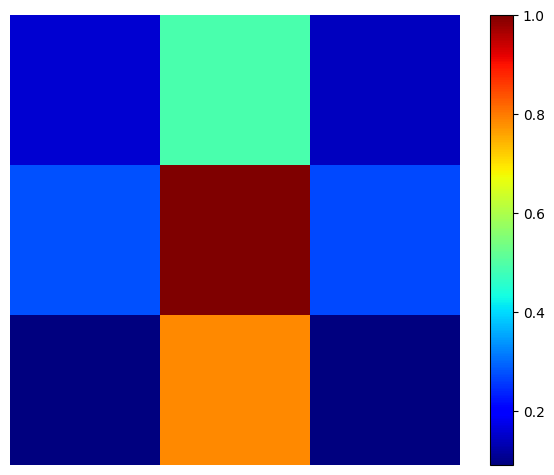

In [36]:
act, grad = None, None

# Loop over hook lists hookF, hookB and extract the activation and gradient of the resnet.layer4.1.conv2 layer
print('***'*3+'  Forward and Backward Hooks extraction  '+'***'*3)
for hook in hookF:
    if hook.name == 'layer4.1.conv2':
        act = hook.output.detach()
        print('Foward hooks:')
        print('output of', hook.name)
        print(act.shape)
        print('-'*20)

for hook in hookB:
    if hook.name == 'layer4.1.conv2':
        print('Backward hooks:')
        grad = hook.output[0].detach()
        print('gradient of', hook.name)
        print(grad.shape)
        print('-'*20)
        
# Global Average Pool the gradients of every feature map (Eq. 1)
pooled_grad = torch.mean(grad, dim=[0, 2, 3])
print('GAP gradients shape:', pooled_grad.shape)

# Multiply every channel k of the activations by GAP gradients, that are the 'weights'
for i in range(act.shape[1]):
    act[:, i, :, :] *= pooled_grad[i]

# Sum across all k-features (Eq. 2)
heatmap = torch.sum(act, dim=1).squeeze().cpu()

# Relu (Eq. 2)
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap between 0 and 1
heatmap /= torch.max(heatmap)
print('Heatmap shape:', heatmap.shape)

# Visualize the raw CAM
plt.imshow(heatmap.numpy(), cmap='jet'); plt.axis('off'); plt.tight_layout(); plt.colorbar(); plt.show()


Image shape (80, 76, 1). Heatmap shape (80, 76)


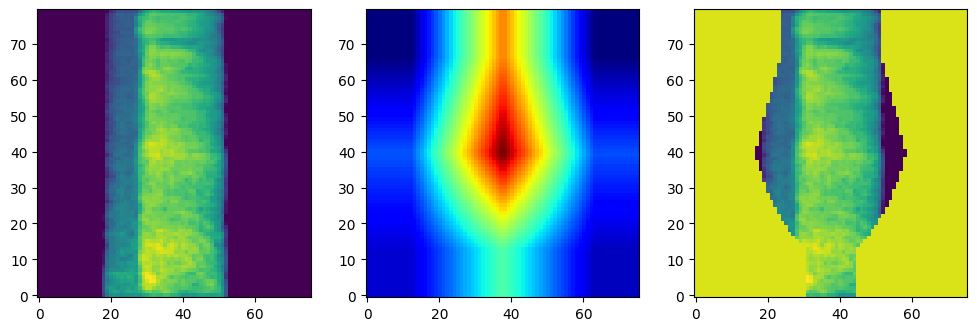

In [37]:
###### GO
x = audio.squeeze(0).cpu().numpy()
img_jpeg = np.stack([x] * 1, axis=-1) 
H, W = img_jpeg.shape[0], img_jpeg.shape[1]

heatmap = cv2.resize(np.array(heatmap), (W, H))
print(f'Image shape {img_jpeg.shape}. Heatmap shape {heatmap.shape}')

mask = heatmap > 0.4
superimposed_img = img_jpeg.copy()
superimposed_img[:,:,0] = img_jpeg[:,:,0] * mask

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(img_jpeg, origin='lower')

plt.subplot(132)
plt.imshow(heatmap, origin='lower', cmap='jet')

plt.subplot(133)
plt.imshow(superimposed_img, origin='lower')

  0%|          | 0/9097 [00:00<?, ?it/s]/run/media/fourier/Data1/Pras/Thesis_Nexus/.env/lib/python3.8/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/run/media/fourier/Data1/Pras/Thesis_Nexus/.env/lib/python3.8/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 505/505 [34:03<00:00,  4.05s/it]


Saved mean heatmaps for label 0 and 1.


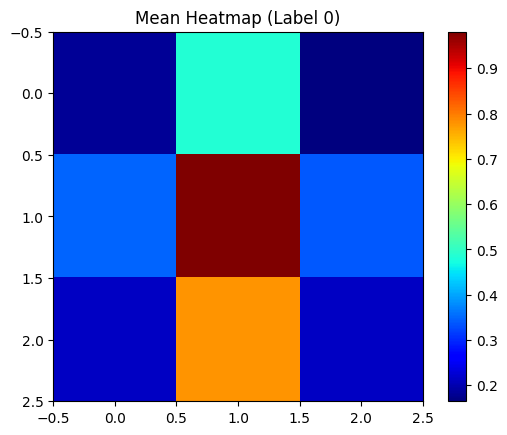

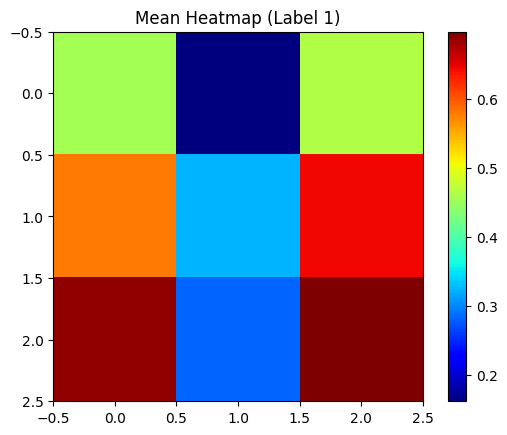

In [65]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn import functional as F

# === Hook class for capturing activations and gradients ===
class Hook():
    def __init__(self, name, module, backward=False):
        self.name = name 
        if not backward:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    
    def close(self):
        self.hook.remove()

# Register hooks
hookF = [Hook(name, layer) for name, layer in pool_model.named_modules()]
hookB = [Hook(name, layer, backward=True) for name, layer in pool_model.named_modules()]

# Set model to eval
pool_model.eval()

# Containers
heatmaps_label0 = []
heatmaps_label1 = []
correct_wavnames = []

# === Loop through data ===
for loader in [train_loader, val_loader]:
    for batch_idx, (wav_names, audio, attention_masks, dse_ids, spk_ids) in enumerate(tqdm(loader)):
        audio = audio.cuda(non_blocking=True).float().squeeze(1)
        attention_masks = attention_masks.cuda(non_blocking=True).float()
        dse_ids = dse_ids.cuda(non_blocking=True).float()

        x_lengths = torch.tensor(commons.compute_length_from_mask(attention_masks)).cuda(non_blocking=True).long()
        outputs = pool_model(audio)[0]
        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(dse_ids, dim=-1)

        for i in range(audio.size(0)):
            pred_label = preds[i].item()
            true_label = true_labels[i].item()

            if pred_label != true_label:
                continue  # skip misclassified

            # Backward CAM
            pool_model.zero_grad()
            output = pool_model(audio[i:i+1])[0]
            output[0, pred_label].backward()

            # Find activation & gradient
            act, grad = None, None
            for hook in hookF:
                if hook.name == 'layer4.1.conv2':
                    act = hook.output.detach()
            for hook in hookB:
                if hook.name == 'layer4.1.conv2':
                    grad = hook.output[0].detach()

            # Compute weights and heatmap
            pooled_grad = torch.mean(grad, dim=[0, 2, 3])
            for j in range(act.shape[1]):
                act[:, j, :, :] *= pooled_grad[j]
            heatmap = torch.sum(act, dim=1).squeeze().cpu()
            heatmap = np.maximum(heatmap, 0)
            max_val = torch.max(heatmap)
            if max_val > 0:
                heatmap = heatmap / max_val
                heatmap = heatmap.numpy()

                if true_label == 0:
                    heatmaps_label0.append(heatmap)
                elif true_label == 1:
                    heatmaps_label1.append(heatmap)
                correct_wavnames.append(wav_names[i])

# === Average and Save Heatmaps ===
mean_heatmap_0 = np.mean(heatmaps_label0, axis=0) if heatmaps_label0 else None
mean_heatmap_1 = np.mean(heatmaps_label1, axis=0) if heatmaps_label1 else None

np.save("mean_heatmap_label0.npy", mean_heatmap_0)
np.save("mean_heatmap_label1.npy", mean_heatmap_1)

print("Saved mean heatmaps for label 0 and 1.")

# === Optional: Visualize ===
import matplotlib.pyplot as plt
if mean_heatmap_0 is not None:
    plt.imshow(mean_heatmap_0, cmap='jet')
    plt.title("Mean Heatmap (Label 0)")
    plt.colorbar()
    plt.show()

if mean_heatmap_1 is not None:
    plt.imshow(mean_heatmap_1, cmap='jet')
    plt.title("Mean Heatmap (Label 1)")
    plt.colorbar()
    plt.show()


Saved mean heatmaps for label 0 and 1.


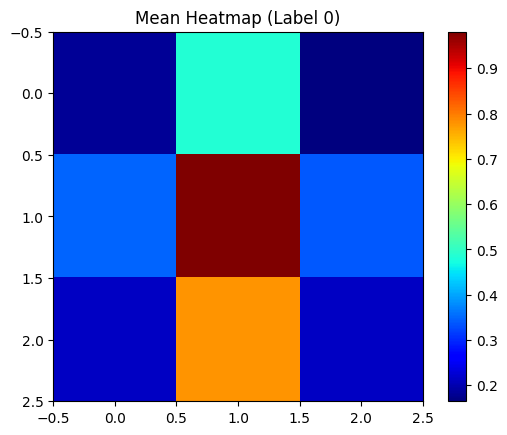

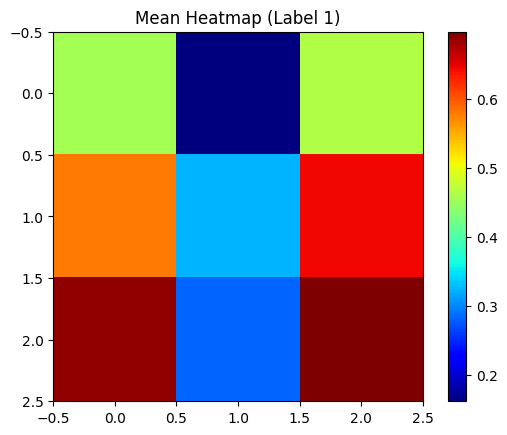

In [66]:
# === Average and Save Heatmaps ===
mean_heatmap_0 = np.mean(heatmaps_label0, axis=0) if heatmaps_label0 else None
mean_heatmap_1 = np.mean(heatmaps_label1, axis=0) if heatmaps_label1 else None

np.save("mean_heatmap_label0.npy", mean_heatmap_0)
np.save("mean_heatmap_label1.npy", mean_heatmap_1)

print("Saved mean heatmaps for label 0 and 1.")

# === Optional: Visualize ===
import matplotlib.pyplot as plt
if mean_heatmap_0 is not None:
    plt.imshow(mean_heatmap_0, cmap='jet')
    plt.title("Mean Heatmap (Label 0)")
    plt.colorbar()
    plt.show()

if mean_heatmap_1 is not None:
    plt.imshow(mean_heatmap_1, cmap='jet')
    plt.title("Mean Heatmap (Label 1)")
    plt.colorbar()
    plt.show()

Image shape (80, 76, 1). Heatmap shape (80, 76)


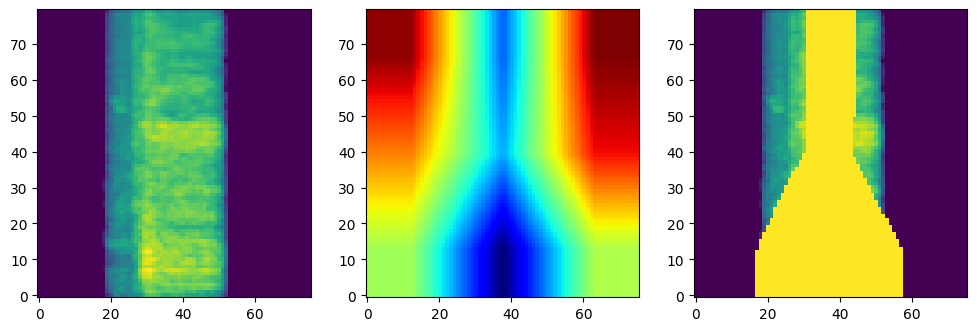

In [69]:
###### GO
x = audio.squeeze(0).cpu().numpy()[0]
img_jpeg = np.stack([x] * 1, axis=-1) 
H, W = img_jpeg.shape[0], img_jpeg.shape[1]

heatmap = cv2.resize(np.array(mean_heatmap_1), (W, H))
print(f'Image shape {img_jpeg.shape}. Heatmap shape {heatmap.shape}')

mask = heatmap > 0.4
superimposed_img = img_jpeg.copy()
superimposed_img[:,:,0] = img_jpeg[:,:,0] * mask

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(img_jpeg, origin='lower')

plt.subplot(132)
plt.imshow(heatmap, origin='lower', cmap='jet')

plt.subplot(133)
plt.imshow(superimposed_img, origin='lower')

Image shape (80, 76, 1). Heatmap shape (80, 76)


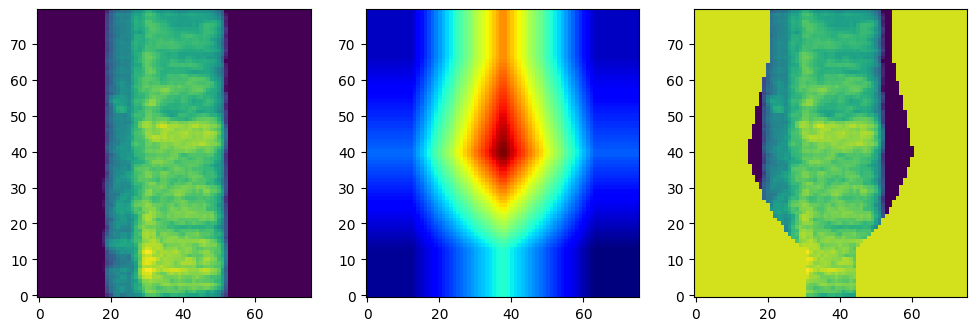

In [70]:
###### GO
x = audio.squeeze(0).cpu().numpy()[0]
img_jpeg = np.stack([x] * 1, axis=-1) 
H, W = img_jpeg.shape[0], img_jpeg.shape[1]

heatmap = cv2.resize(np.array(mean_heatmap_0), (W, H))
print(f'Image shape {img_jpeg.shape}. Heatmap shape {heatmap.shape}')

mask = heatmap > 0.4
superimposed_img = img_jpeg.copy()
superimposed_img[:,:,0] = img_jpeg[:,:,0] * mask

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(img_jpeg, origin='lower')

plt.subplot(132)
plt.imshow(heatmap, origin='lower', cmap='jet')

plt.subplot(133)
plt.imshow(superimposed_img, origin='lower')